# Load data

In [ ]:
import os
import requests
from tqdm import tqdm
import zipfile
from pandas import read_csv
import pandas as pd
import numpy as np
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import KFold
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Conv1D, Activation, Flatten, Dense, Input, MaxPooling1D, Dropout, Add, Activation
from keras.utils import plot_model
from keras.models import Sequential
from keras.regularizers import l2
import seaborn as sns
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from keras import layers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
print("####### LOCALIZATION")

def download_data():
    url="https://github.com/JJAlmagro/subcellular_localization/raw/refs/heads/master/notebook%20tutorial/data/reduced_train.npz"
    datasetFolderPath = "dataset/"
    file = "reduced_train.npz"
    FilePath = os.path.join(datasetFolderPath, file)

    if not os.path.exists(datasetFolderPath):
        os.makedirs(datasetFolderPath)

    def download_file(url, filename):
        response = requests.get(url, stream=True)
        with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                           total=int(response.headers.get('content-length', 0)),
                           desc=filename) as fout:
            for chunk in response.iter_content(chunk_size=4096):
                fout.write(chunk)

    # Download the zip file if it does not exist
    if not os.path.exists(FilePath):
        download_file(url, FilePath)

download_data()

####### LOCALIZATION


dataset/reduced_train.npz: 100%|██████████| 8.52M/8.52M [00:00<00:00, 58.9MB/s]


# Data processing

In [ ]:
# Data treatment
file_data_train = "dataset/reduced_train.npz"

train = np.load(file_data_train)
X_train = train["X_train"]
Y = train["y_train"]
mask_train = train["mask_train"]

# Print these to visualize.
print("Shape of dataset X")
print(X_train.shape)
print("Shape of dataset Y")
print(Y.shape)
print("Shape of dataset Mask")
print(mask_train.shape)
classes = preprocessing.LabelEncoder()
classes.fit(Y)
classes_Y = classes.transform(Y)

onehot_Y = keras.utils.to_categorical(classes_Y)

print("First 5 rows of X_train:\n", X_train[:5])
print("First 5 elements of Y (original):\n", Y[:5])
print("First 5 rows of mask_train:\n", mask_train[:5])

print("First 5 rows of one-hot encoded Y:\n", onehot_Y[:5])
print("Shape of dataset onehot_Y")
print(onehot_Y.shape)

Shape of dataset X
(2423, 400, 20)
Shape of dataset Y
(2423,)
Shape of dataset Mask
(2423, 400)
First 5 rows of X_train:
 [[[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.48 0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.  

In [ ]:
# Example: Statistics for the first feature across all samples and time points
df = pd.DataFrame(X_train[:, :, 0])
stats = df.describe()
print(stats)

               0            1            2            3            4    \
count  2423.000000  2423.000000  2423.000000  2423.000000  2423.000000   
mean      0.021865     0.205510     0.099270     0.075233     0.088902   
std       0.114765     0.298014     0.175479     0.142319     0.156582   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.050000     0.020000     0.020000     0.030000   
75%       0.000000     0.300000     0.120000     0.090000     0.100000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               5            6            7            8            9    ...  \
count  2423.000000  2423.000000  2423.000000  2423.000000  2423.000000  ...   
mean      0.085184     0.093553     0.089930     0.100896     0.099030  ...   
std       0.145490     0.159008     0.150393     0.156734     0.152685  ...   
min       0.00000

In [ ]:
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
    X_train, onehot_Y, test_size=0.2, random_state=42)

print("Shape of X_train_split:", X_train_split.shape)
print("Shape of Y_train_split:", Y_train_split.shape)

print("Shape of X_val_split:", X_val_split.shape)
print("Shape of Y_val_split:", Y_val_split.shape)

Shape of X_train_split: (1938, 400, 20)
Shape of Y_train_split: (1938, 10)
Shape of X_val_split: (485, 400, 20)
Shape of Y_val_split: (485, 10)


# CNN

## Model Construction

In [ ]:
def cnn_functional(input_shape=(400, 20), num_classes=10):
    # Create a Sequential model
    model = Sequential()

    # First convolutional layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Second convolutional layer
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Flatten layer
    model.add(Flatten())

    # Fully connected layer with L2 regularization
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))

    # Dropout layer for regularization
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = cnn_functional()
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)                   │ (None, 398, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 199, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 199, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 197, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 98, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 98, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,635,658 (6.24 MB)

 Trainable params: 1,635,658 (6.24 MB)

 Non-trainable params: 0 (0.00 B)

## Training model

In [ ]:
history = model.fit(X_train_split, Y_train_split, epochs=10, batch_size=32, validation_data=(X_val_split, Y_val_split))

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.2744 - loss: 4.2972 - val_accuracy: 0.3608 - val_loss: 2.4255
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.3943 - loss: 2.3218 - val_accuracy: 0.6124 - val_loss: 1.8512
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5895 - loss: 1.7855 - val_accuracy: 0.6887 - val_loss: 1.5932
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6589 - loss: 1.6033 - val_accuracy: 0.6474 - val_loss: 1.5649
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.6621 - loss: 1.5276 - val_accuracy: 0.6969 - val_loss: 1.4789
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.6862 - loss: 1.4919 - val_accuracy: 0.7052 - val_loss: 1.4942
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.7013 - loss: 1.4479 - val_accuracy: 0.7155 - val_loss: 1.4585
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.7073 - loss: 1.4222 - val_accuracy: 0.7216 

## Results with graphs

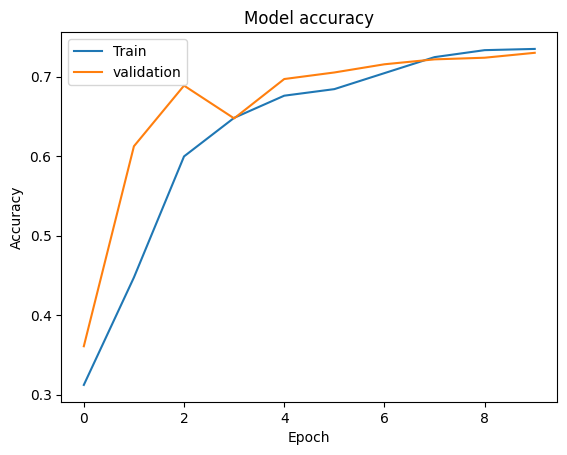

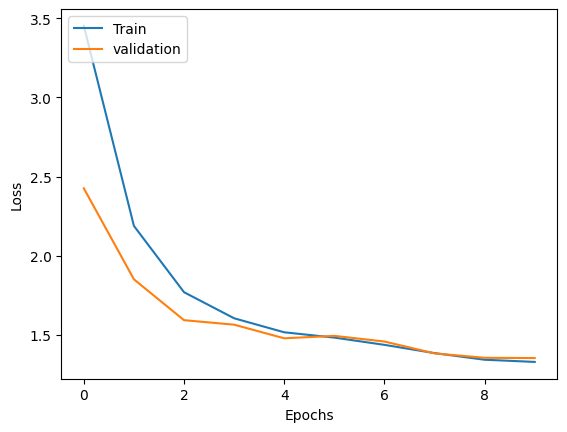

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_val_split, Y_val_split)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7527 - loss: 1.3353


[1.3539727926254272, 0.7298969030380249]

## Confusion matrix

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Axes: >

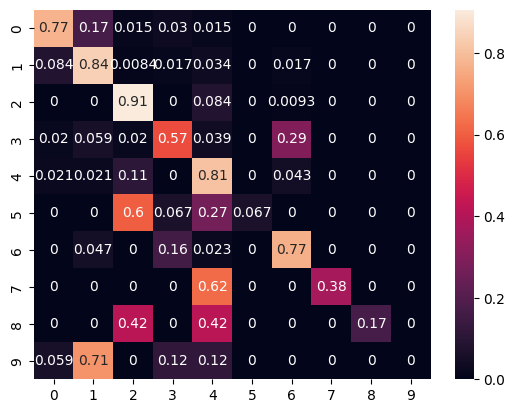

In [ ]:
y_test_classes = np.argmax(Y_val_split,axis = 1)
y_predcnn = model.predict(X_val_split)
y_predcnn_classes = np.argmax(y_predcnn,axis = 1)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_predcnn_classes, normalize="true"), annot=True)

## Result

For this first model, we are using a CNN. We achieve good learning when looking at the curves. However, we don't obtain a very good prediction because our dataset does not contain enough data to improve the prediction.

# Cross validation

 ## Data processing

In [ ]:
# Data treatment
file_data_train = "dataset/reduced_train.npz"

train = np.load(file_data_train)
X_train = train["X_train"]
Y = train["y_train"]
mask_train = train["mask_train"]

# Print these to visualize.
print("Shape of dataset X")
print(X_train.shape)
print("Shape of dataset Y")
print(Y.shape)
print("Shape of dataset Mask")
print(mask_train.shape)
classes = preprocessing.LabelEncoder()
classes.fit(Y)
classes_Y = classes.transform(Y)

onehot_Y = keras.utils.to_categorical(classes_Y)

Shape of dataset X
(2423, 400, 20)
Shape of dataset Y
(2423,)
Shape of dataset Mask
(2423, 400)


## Cross validation

In [ ]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

all_train_acc = []
all_train_loss = []
val_acc_per_epoch = []
val_loss_per_epoch = []
confusion_matrices = []

# Préparez des listes pour stocker les valeurs de validation pour chaque epoch
val_acc_epochs = None
val_loss_epochs = None

# Boucle sur chaque fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = onehot_Y[train_index], onehot_Y[val_index]

    model = cnn_functional()

    history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32,
                        validation_data=(X_val_fold, y_val_fold), verbose=0)

    all_train_acc.append(history.history['accuracy'])
    all_train_loss.append(history.history['loss'])

    # Initialisez les listes val_acc_epochs et val_loss_epochs lors de la première itération
    if val_acc_epochs is None:
        val_acc_epochs = np.array(history.history['val_accuracy'])
        val_loss_epochs = np.array(history.history['val_loss'])
    else:
        val_acc_epochs += np.array(history.history['val_accuracy'])
        val_loss_epochs += np.array(history.history['val_loss'])

    y_test_classes = np.argmax(y_val_fold, axis=1)
    y_predcnn = model.predict(X_val_fold)
    y_predcnn_classes = np.argmax(y_predcnn, axis=1)

    cm = sklearn.metrics.confusion_matrix(y_test_classes, y_predcnn_classes, normalize="true")
    confusion_matrices.append(cm)

    print(f"Fold {fold + 1}: validation accuracy = {max(history.history['val_accuracy']):.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Fold 1: validation accuracy = 0.7567


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Fold 2: validation accuracy = 0.7649


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Fold 3: validation accuracy = 0.7588


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Fold 4: validation accuracy = 0.7562


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Fold 5: validation accuracy = 0.7975


## Results with graphs

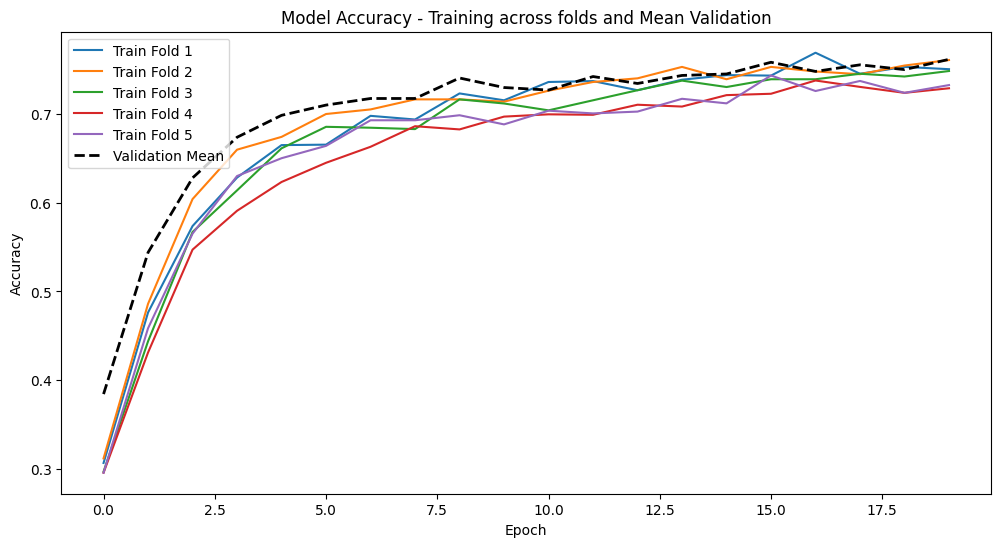

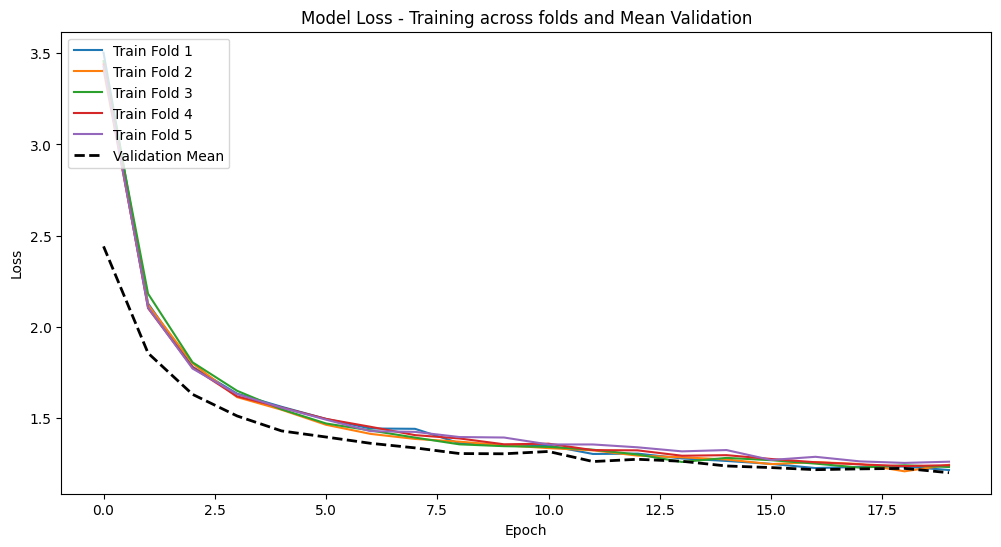

In [ ]:
# Faites la moyenne des valeurs de validation
val_acc_mean = val_acc_epochs / k_folds
val_loss_mean = val_loss_epochs / k_folds

# Tracez les courbes de précision
plt.figure(figsize=(12, 6))

for i in range(k_folds):
    plt.plot(all_train_acc[i], label=f'Train Fold {i+1}', linestyle='-')

plt.plot(val_acc_mean, label='Validation Mean', color='black', linestyle='--', linewidth=2)
plt.title('Model Accuracy - Training across folds and Mean Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Tracez les courbes de perte
plt.figure(figsize=(12, 6))

for i in range(k_folds):
    plt.plot(all_train_loss[i], label=f'Train Fold {i+1}', linestyle='-')

plt.plot(val_loss_mean, label='Validation Mean', color='black', linestyle='--', linewidth=2)
plt.title('Model Loss - Training across folds and Mean Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [ ]:
# Calculate and print average validation accuracy
average_accuracy = np.mean([max(val_acc) for val_acc in all_train_acc])
print(f"Average maximum validation accuracy over {k_folds} folds: {average_accuracy:.4f}")

Average maximum validation accuracy over 5 folds: 0.7474


## Confusion matrix

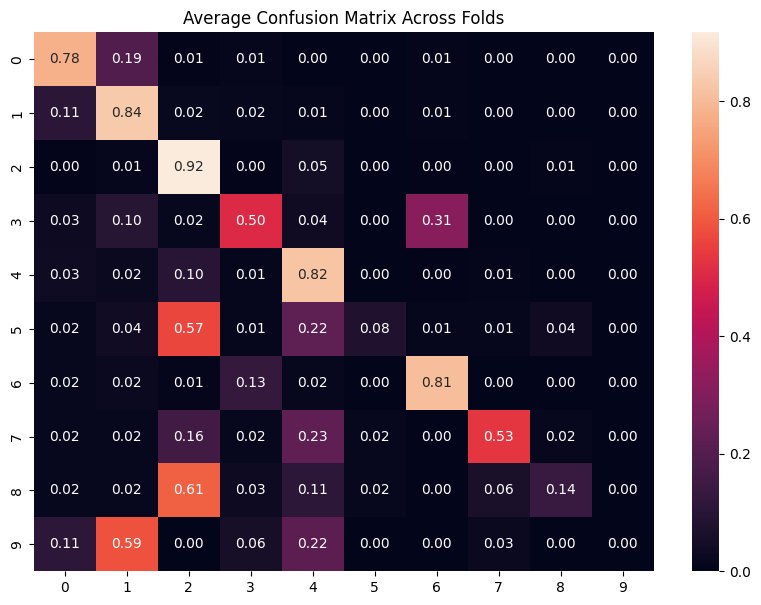

In [ ]:
# Stack and average the confusion matrices
avg_confusion_matrix = np.mean(np.array(confusion_matrices), axis=0)

# Plot the averaged confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(avg_confusion_matrix, annot=True, fmt='.2f')
plt.title('Average Confusion Matrix Across Folds')
plt.show()

## Results

This cross validation help to do a better analysis on our data. It is more precise due to the low number of data that we have in the database. We have a good learning with a prediction around 75%.

# Resnet

## Data processing

In [ ]:
# Data treatment
file_data_train = "dataset/reduced_train.npz"

train = np.load(file_data_train)
X_train = train["X_train"]
Y = train["y_train"]
mask_train = train["mask_train"]

# Print these to visualize.
print("Shape of dataset X")
print(X_train.shape)
print("Shape of dataset Y")
print(Y.shape)
print("Shape of dataset Mask")
print(mask_train.shape)
classes = preprocessing.LabelEncoder()
classes.fit(Y)
classes_Y = classes.transform(Y)

onehot_Y = keras.utils.to_categorical(classes_Y)

Shape of dataset X
(2423, 400, 20)
Shape of dataset Y
(2423,)
Shape of dataset Mask
(2423, 400)


## Model construction

In [ ]:
# Fonction pour créer un bloc résiduel
def residual_block(x, filters, kernel_size=3, strides=1, activation='relu', reg=l2(0.01)):
    # Première couche de convolution
    conv = Conv1D(filters, kernel_size, padding='same', strides=strides, kernel_regularizer=reg)(x)
    conv = Activation(activation)(conv)

    # Deuxième couche de convolution
    conv = Conv1D(filters, kernel_size, padding='same', kernel_regularizer=reg)(conv)

    # Ajout de la connexion résiduelle (skip connection)
    shortcut = x
    if strides != 1 or x.shape[-1] != filters:
        # Si les dimensions ne correspondent pas, ajuster le shortcut pour correspondre
        shortcut = Conv1D(filters, kernel_size=1, strides=strides, padding='same', kernel_regularizer=reg)(x)

    # Addition du shortcut et de la sortie de la couche conv
    output = Add()([conv, shortcut])
    output = Activation(activation)(output)

    return output

# Entrée du modèle
input_shape = (400, 20)
inputs = Input(shape=input_shape)

# Première couche de convolution (sans skip connection)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.5)(x)

# Bloc résiduel 1
x = residual_block(x, filters=64)

# Bloc résiduel 2
x = residual_block(x, filters=128, strides=2)
x = Dropout(0.5)(x)

# Bloc résiduel 3
x = residual_block(x, filters=128)

# Couche de flatten
x = Flatten()(x)

# Couche fully connected avec régularisation L2
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)

# Couche de sortie
outputs = Dense(10, activation='softmax')(x)

# Modèle final
model = Model(inputs, outputs)

# Compilation du modèle
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()

Model: "functional_467"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46            │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_98 (Conv1D)        │ (None, 400, 64)        │          3,904 │ input_layer_46[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_91          │ (None, 200, 64)        │              0 │ conv1d_98[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_138 (Dropout)     │ (None, 200, 64)        │              0 │ max_pooling1d_91[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_99 (Conv1D)        │ (None, 200, 64)        │         12,352 │ dropout_138[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 200, 64)        │              0 │ conv1d_99[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_100 (Conv1D)       │ (None, 200, 64)        │         12,352 │ activation_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 200, 64)        │              0 │ conv1d_100[0][0],      │
│                           │                        │                │ dropout_138[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_7 (Activation) │ (None, 200, 64)        │              0 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_101 (Conv1D)       │ (None, 100, 128)       │         24,704 │ activation_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 100, 128)       │              0 │ conv1d_101[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_102 (Conv1D)       │ (None, 100, 128)       │         49,280 │ activation_8[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_103 (Conv1D)       │ (None, 100, 128)       │          8,320 │ activation_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 100, 128)       │              0 │ conv1d_102[0][0],      │
│                           │                        │                │ conv1d_103[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_9 (Activation) │ (None, 100, 128)       │              0 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_139 (Dropout)     │ (None, 100, 128)       │              0 │ activation_9[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_104 (Conv1D)       │ (None, 100, 128)       │         49,280 │ dropout_139[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10        

 Total params: 1,849,290 (7.05 MB)

 Trainable params: 1,849,290 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

## Training model

In [ ]:
history = model.fit(X_train_split, Y_train_split, epochs=20, batch_size=32, validation_data=(X_val_split, Y_val_split))

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - accuracy: 0.2623 - loss: 8.8208 - val_accuracy: 0.2784 - val_loss: 3.9769
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.3107 - loss: 3.3520 - val_accuracy: 0.4412 - val_loss: 2.3560
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - accuracy: 0.4264 - loss: 2.2522 - val_accuracy: 0.4907 - val_loss: 1.9346
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step - accuracy: 0.4523 - loss: 1.9805 - val_accuracy: 0.5608 - val_loss: 1.7529
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.4951 - loss: 1.7976 - val_accuracy: 0.5608 - val_loss: 1.6238
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.5499 - loss: 1.6478 - val_accuracy: 0.5938 - val_loss: 1.5149
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.6064 - loss: 1.5408 - val_accuracy: 0.6124 - val_loss: 1.4739
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - accuracy: 0.6192 - loss: 1.4463 - val_accu

In [ ]:
model.evaluate(X_val_split, Y_val_split)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7039 - loss: 1.2496


[1.2436844110488892, 0.692783534526825]

## Results with graphs

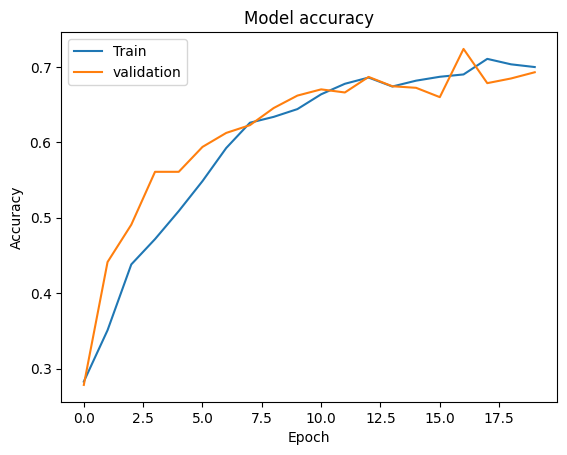

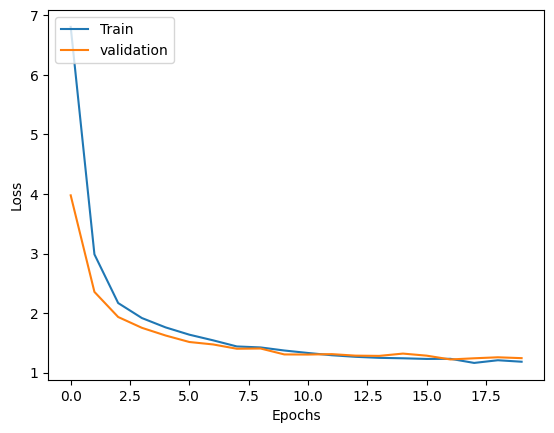

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

## Confusion matrix

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step


<Axes: >

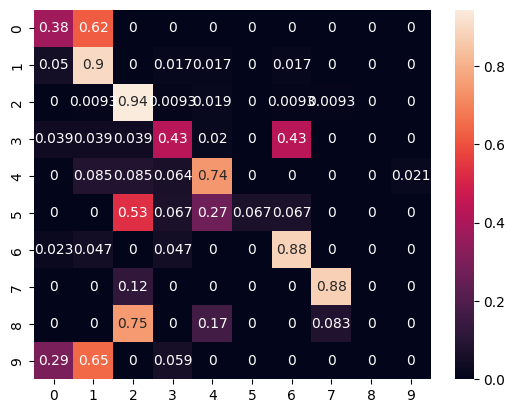

In [ ]:
y_test_classes = np.argmax(Y_val_split,axis = 1)
y_predcnn = model.predict(X_val_split)
y_predcnn_classes = np.argmax(y_predcnn,axis = 1)
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_predcnn_classes, normalize="true"), annot=True)

## Results

With the Resnet method, we don't have better results than with other methods